In [52]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Import necessary libraries
import sys
from pathlib import Path
# Ensure the src directory is accessible
sys.path.append('./src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [53]:
from get_data import get_data
data_sets = get_data() 

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
100%|██████████| 306893/306893 [01:41<00:00, 3034.74it/s]


# Check data: make sure no drugs are replicated across training, validation and test sets 

In [54]:
set(data_sets['du']['train']['Drug_ID']).intersection(set(data_sets['karim']['train']['Drug_ID']))

set()

In [55]:
set(data_sets['du']['train']['Drug_ID']).intersection(set(data_sets['wang']['train']['Drug_ID']))

set()

# Featuring functions

In [56]:
from features import smiles_to_fp

# Prepare the data
def prepare_data(df):
    df['features'] = df['Drug'].apply(lambda x: smiles_to_fp(x))
    X = list(df['features'])
    y = df['Y'].values
    return X, y


# Prepare traing and test data

In [57]:
# make features
X_train, y_train = prepare_data(data_sets['du']['train'])
X_valid, y_valid = prepare_data(data_sets['du']['valid'])
X_test, y_test = prepare_data(data_sets['du']['test'])


In [64]:
X_ext_test1, y_ext_test1 = prepare_data(data_sets['karim']['train'])
X_ext_test2, y_ext_test2 = prepare_data(data_sets['wang']['train']) 

654

# Random Forest Classifier

In [58]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# Evaluation on validation data

In [60]:
from evaluate import eval
y_pred = rf_model.predict(X_valid)
result = eval(y_valid, y_pred, verbose=True)

Accuracy: 0.9553571428571429
ROC AUC Score: 0.5678513397595961
Precision: 0.6455696202531646
Recall: 0.13953488372093023
F1 Score: 0.22947131608548932
Matthews Correlation Coefficient: 0.2863298082899073
Specificity (Negative Prediction Accuracy): 0.9961677957982619


# Evaluation on internal test data

In [61]:
y_pred = rf_model.predict(X_test)
result = eval(y_test, y_pred, verbose=True)

Accuracy: 0.9605108823146097
ROC AUC Score: 0.5491156434548832
Precision: 0.7926829268292683
Recall: 0.09938837920489296
F1 Score: 0.1766304347826087
Matthews Correlation Coefficient: 0.27216862724423885
Specificity (Negative Prediction Accuracy): 0.9988429077048734


# Evaluation on external data (Wang and Karim)

In [65]:
y_pred1 = rf_model.predict(X_ext_test1)
result = eval(y_ext_test1, y_pred1, verbose=True)

Accuracy: 0.5067311268129416
ROC AUC Score: 0.506401212374247
Precision: 0.9479166666666666
Recall: 0.013545698124441799
F1 Score: 0.02670971529204579
Matthews Correlation Coefficient: 0.07602614372377121
Specificity (Negative Prediction Accuracy): 0.9992567266240523


In [66]:
y_pred2 = rf_model.predict(X_ext_test2)
result = eval(y_ext_test2, y_pred2, verbose=True)

Accuracy: 0.332824427480916
ROC AUC Score: 0.5155210643015521
Precision: 1.0
Recall: 0.031042128603104215
F1 Score: 0.060215053763440864
Matthews Correlation Coefficient: 0.09939437698551633
Specificity (Negative Prediction Accuracy): 1.0


 # SimpleNN: Define the model

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 64),  # Assuming input features size of 1024
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),  # binary classification
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# SimpleNN: Define loss

In [68]:

def nn_loss_func(outputs, targets):
    criterion = nn.BCELoss()
    classical_loss = criterion(outputs.squeeze(), targets.squeeze())
    
    return classical_loss 

# SimpleNN: Training

In [69]:
def train_epoch(model, X_train, y_train, optimizer, criterion):
    model.train()
    nn_optimizer.zero_grad()
    outputs = nn_model(X_train)  # Make sure X_train is a tensor
    loss = criterion(outputs, y_train)  # Ensure y_train is appropriately shaped
    loss.backward()
    nn_optimizer.step()
    return loss


In [70]:
from evaluate import eval

def eval_model(model, X_test, y_test, verbose=False):
    model.eval()

    # Disable gradient computation for testing (saves memory and computations)
    with torch.no_grad():
        outputs = model(X_test)

    # Convert outputs to predicted classes
    # For binary classification with a single output unit
    predictions = (outputs > 0.5).float()  # Threshold probabilities to classify as 1 or 0

    # Since you cannot use sklearn directly with tensors, you need to move data back to CPU and convert to numpy
    predictions = predictions.cpu().numpy()
    y_test = y_test.cpu().numpy()

    return eval(y_test, predictions, verbose=verbose)  



In [76]:
nn_model = SimpleNN()
nn_optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

X_train = torch.tensor(X_train, dtype=torch.float32)  # Convert features to a float Tensor
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Convert labels to a float Tensor
X_valid = torch.tensor(X_valid, dtype=torch.float32)  # Convert features to a float Tensor
y_valid = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(1)  # Convert labels to a float Tensor

# Train the model
num_epochs = 100
total_losses = []
total_auc = []
for epoch in range(num_epochs):
    train_loss = train_epoch(nn_model, X_train, y_train, nn_optimizer, nn_loss_func)
    valid_metrics = eval_model(nn_model, X_valid, y_valid)
    total_losses.append(train_loss)
    total_auc.append(valid_metrics['roc_auc'])
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation AUC: {valid_metrics['roc_auc']}")


Epoch 0, Train Loss: 0.7634, Validation AUC: 0.5
Epoch 1, Train Loss: 0.7403, Validation AUC: 0.4800371237760954
Epoch 2, Train Loss: 0.7167, Validation AUC: 0.4308416610474548
Epoch 3, Train Loss: 0.6921, Validation AUC: 0.4745376448813497
Epoch 4, Train Loss: 0.6659, Validation AUC: 0.49722849517552864
Epoch 5, Train Loss: 0.6376, Validation AUC: 0.49972627112844725
Epoch 6, Train Loss: 0.6068, Validation AUC: 0.49993156778211184
Epoch 7, Train Loss: 0.5739, Validation AUC: 0.5
Epoch 8, Train Loss: 0.5395, Validation AUC: 0.5
Epoch 9, Train Loss: 0.5041, Validation AUC: 0.5
Epoch 10, Train Loss: 0.4682, Validation AUC: 0.5
Epoch 11, Train Loss: 0.4324, Validation AUC: 0.5
Epoch 12, Train Loss: 0.3972, Validation AUC: 0.5
Epoch 13, Train Loss: 0.3636, Validation AUC: 0.5
Epoch 14, Train Loss: 0.3322, Validation AUC: 0.5
Epoch 15, Train Loss: 0.3036, Validation AUC: 0.5
Epoch 16, Train Loss: 0.2784, Validation AUC: 0.5
Epoch 17, Train Loss: 0.2570, Validation AUC: 0.5
Epoch 18, Train L

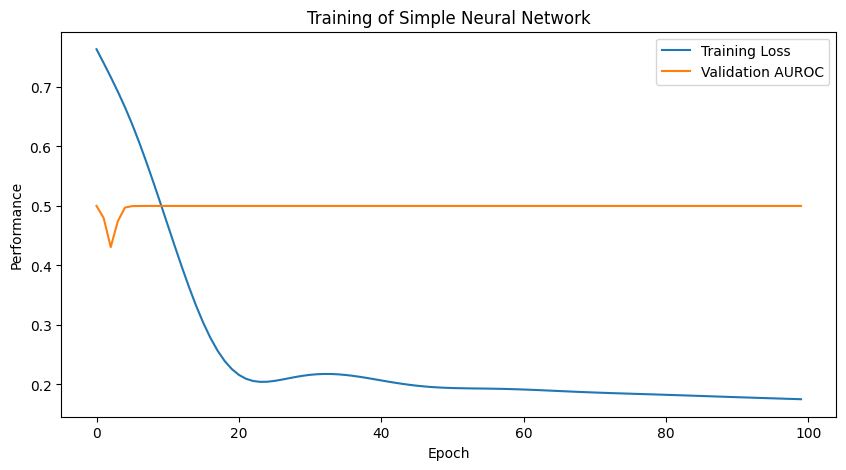

In [77]:
import matplotlib.pyplot as plt

# Converting tensors to lists of scalars
total_losses = [x.item() for x in total_losses]
total_auc = [x.item() for x in total_auc]

# Plotting the values
plt.figure(figsize=(10, 5))
plt.plot(total_losses, label='Training Loss')
plt.plot(total_auc, label='Validation AUROC')
plt.title('Training of Simple Neural Network')
plt.xlabel('Epoch')
plt.ylabel('Performance')
plt.legend()
plt.show()

# SimpleNN on Test Data

In [78]:
# convert to tensor
X_test = torch.tensor(X_test, dtype=torch.float32)  
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)  # Convert to tensor and ensure correct shape
result = eval_model(nn_model, X_test, y_test, verbose=True)

Accuracy: 0.9573830314088362
ROC AUC Score: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Matthews Correlation Coefficient: 0.0
Specificity (Negative Prediction Accuracy): 1.0


# SimpleNN on External Test Data

In [80]:
# convert to tensor
X_ext_test1 = torch.tensor(X_ext_test1, dtype=torch.float32)  
y_ext_test1 = torch.tensor(y_ext_test1, dtype=torch.float32).unsqueeze(1)  # Convert to tensor and ensure correct shape
result = eval_model(nn_model, X_ext_test1, y_ext_test1, verbose=True)

Accuracy: 0.5003346969133506
ROC AUC Score: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Matthews Correlation Coefficient: 0.0
Specificity (Negative Prediction Accuracy): 1.0


In [81]:
# convert to tensor
X_ext_test2 = torch.tensor(X_ext_test2, dtype=torch.float32)  
y_ext_test2 = torch.tensor(y_ext_test2, dtype=torch.float32).unsqueeze(1)  # Convert to tensor and ensure correct shape
result = eval_model(nn_model, X_ext_test2, y_ext_test2, verbose=True)

Accuracy: 0.3114503816793893
ROC AUC Score: 0.5
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Matthews Correlation Coefficient: 0.0
Specificity (Negative Prediction Accuracy): 1.0
